# T3.1 Análisis discriminante lineal

**Índice**

> 1 Clasificadores generativos vs discriminativos<br>
>> 1.1 Caracterización<br>
>> 1.2 Ejemplos<br>
>>> 1.2.1 Ejemplo de clasificador generativo<br>
>>> 1.2.2 Ejemplo de clasificador discriminativo<br>
>>
>> 1.3 Ventajas de los clasificadores discriminativos<br>
>> 1.4 Ventajas de los clasificadores generativos<br>
>
> 2 Análisis discriminante Gaussiano<br>
>> 2.1 Asunción Gaussiana<br>
>> 2.2 Análisis discriminante cuadrático (QDA)<br>
>> 2.3 Análisis discriminante lineal (LDA)<br>
>> 2.4 Ajuste del modelo<br>
>>> 2.4.1 Ajuste de modelos generativos con la conjunta<br>
>>> 2.4.2 Análisis discriminante cuadrático (QDA)<br>
>>> 2.4.3 Análisis discriminante lineal (LDA)<br>
>>> 2.4.4 Matrices de covarianzas diagonales<br>
>>> 2.4.5 Análisis discriminante regularizado<br>
>>
>> 2.5 Clasificador por el centroide más próximo<br>
>
> 3 Clasificadores naive Bayes<br>
>> 3.1 Asunción y clasificador naive Bayes<br>
>> 3.2 Modelos ejemplo<br>
>>> 3.2.1 Naive Bayes Bernoulli<br>
>>> 3.2.2 Naive Bayes categórico<br>
>>> 3.2.3 Naive Bayes Gaussiano<br>

<p style="page-break-after:always;"></p>

# 1 Clasificadores generativos vs discriminativos

## 1.1 Caracterización

**Clasificador generativo:** $\;$ expresa **posteriors** en función de **priors** y **densidades condicionales** de las clases, las cuales puede muestrearse para **generar** datos sintéticos
$$p(y=c\mid\boldsymbol{x};\boldsymbol{\theta})=\frac{p(\boldsymbol{x}\mid y=c;\boldsymbol{\theta})\,p(y=c;\boldsymbol{\theta})}{\sum_{c'}p(\boldsymbol{x}\mid y=c';\boldsymbol{\theta})\,p(y=c';\boldsymbol{\theta})}%
\propto p(\boldsymbol{x}\mid y=c;\boldsymbol{\theta})\,p(y=c;\boldsymbol{\theta})$$

**Clasificador discriminativo:** $\;$ modela **posteriors** directamente, sin necesidad de conocer priors y densidades condicionales,
$$p(y=c\mid\boldsymbol{x};\boldsymbol{\theta})=\cdots$$

## 1.2 Ejemplos

In [1]:
import numpy as np
from scipy.stats import multinomial, multivariate_normal
import matplotlib.pyplot as plt

<p style="page-break-after:always;"></p>

### 1.2.1 Ejemplo de clasificador generativo

Sean $\;C=2$, $\;x\in[0,1]$ y los priors y condicionales siguientes:
$$\begin{align*}
p(y=1)&=p(y=2)=0.5&&\text{(clases equiprobables)}\\%
p(x\mid y=1)&=0.6\,\mathcal{N}(\mu=0.1, \sigma=0.09)+0.4\,\mathcal{N}(\mu=0.4, \sigma=0.09)%
&&\text{(mixtura de dos normales)}\\%
p(x\mid y=2)&=\mathcal{N}(\mu=0.7, \sigma=0.09)&&\text{(normal)}%
\end{align*}$$

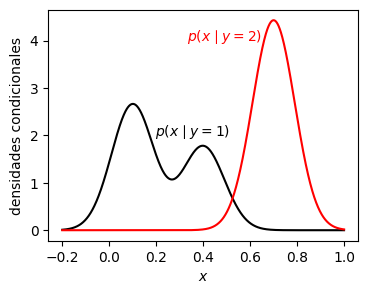

In [2]:
X = np.arange(-0.200, 1.001, 0.001)
def p1(x): return 0.6 * multivariate_normal.pdf(x, 0.1, 0.09**2) \
    + 0.4 * multivariate_normal.pdf(x, 0.4, 0.09**2)
def p2(x): return multivariate_normal.pdf(x, 0.7, 0.09**2)
plt.figure(figsize=(4, 3)); plt.plot(X, p1(X), '-k', X, p2(X), '-r'); plt.xlabel('$x$')
plt.ylabel('densidades condicionales'); plt.annotate('$p(x\mid y=1)$', (0.196, 2), fontsize=10)
plt.annotate('$p(x\mid y=2)$', (0.33, 4), fontsize=10, color='red');

<p style="page-break-after:always;"></p>

Generación de datos sintéticos de acuerdo con la distribución conjunta:
$$\begin{align*}
p(x, y)&=p(y)\,p(x\mid y)&&\text{(primero generamos $y$ y luego $x$ dado $y$)}\\%
p(y)&=\operatorname{Cat}(0.5, 0.5)&&\text{($y$ se genera simulando una categórica)}\\%
p(x\mid y=2)&=\mathcal{N}(0.7, 0.09^2)&&\text{(si $y=2$, $x$ es es un número aleatorio normal)}\\%
\end{align*}$$
La condicional de la clase $1$ puede expresarse en términos de una etiqueta de subclase "perdida", $z\in\{1,2\}$:
$$\begin{align*}
p(x\mid y=1)&=p(x, z=1\mid y=1)+p(x, z=2\mid y=1)\\%
&=p(z=1\mid y=1)\,p(x\mid y=1, z=1)+p(z=2\mid y=1)\,p(x\mid y=1, z=2)\\%
p(z\mid y=1)&=\operatorname{Cat}(0.6, 0.4)\\%
p(x\mid y=1, z=1)&=\mathcal{N}(0.1, 0.09^2)\\%
p(x\mid y=1, z=2)&=\mathcal{N}(0.4, 0.09^2)%
\end{align*}$$

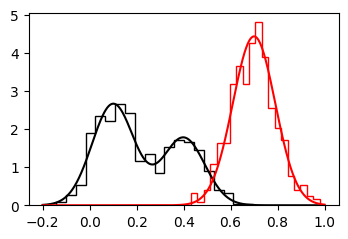

In [3]:
N = 1000; yy = multinomial(1, [0.5, 0.5]).rvs(N); N1 = yy[yy[:, 0] == 1].shape[0]
zz_y1 = multinomial(1, [0.6, 0.4]).rvs(N1); N1_y1 = zz_y1[zz_y1[:, 0] == 1].shape[0]
xx_y1_z1 = multivariate_normal(0.1, 0.09**2).rvs(N1_y1)
xx_y1_z2 = multivariate_normal(0.4, 0.09**2).rvs(N1 - N1_y1)
xx_y2 = multivariate_normal(0.7, 0.09**2).rvs(N - N1); plt.figure(figsize=(4, 2.5))
plt.hist(np.hstack((xx_y1_z1, xx_y1_z2)), bins=20, density=True, histtype='step', ec="black")
plt.hist(np.hstack((xx_y2)), bins=20, density=True, histtype='step', ec="red")
plt.plot(X, p1(X), '-k', X, p2(X), '-r');

<p style="page-break-after:always;"></p>

### 1.2.2 Ejemplo de clasificador discriminativo

Seguimos con $\;C=2$ y $\;x\in[0,1]$, pero no conocemos priors ni densidades condicionales; no obstante, tenemos modelos sencillos de posteriors que producen las mismas regiones y frontera que el ejemplo generativo:
$$\begin{align*}
p(y=1\mid\boldsymbol{x})&=\frac{1}{1+\exp(27x-15)}\\%
p(y=2\mid\boldsymbol{x})&=\frac{1}{1+\exp(-27x+15)}%
\end{align*}$$

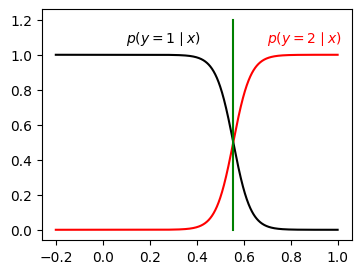

In [4]:
def p1(x): return 1/(1 + np.exp((27*x-15)))
def p2(x): return 1/(1 + np.exp((-27*x+15)))
plt.figure(figsize=(4, 3))
plt.plot(X, p1(X), '-k'); plt.plot(X, p2(X), '-r'); plt.plot([0.556, 0.556], [0, 1.2], '-g')
plt.annotate('$p(y=1\mid x)$', (0.1, 1.07), fontsize=10)
plt.annotate('$p(y=2\mid x)$', (0.7, 1.07), fontsize=10, color='red');

<p style="page-break-after:always;"></p>

## 1.3 Ventajas de los clasificadores discriminativos

**Mejor precisión predictiva:** $\;p(y\mid\boldsymbol{x})$ suele ser más fácil de aprender y no deben "malgastar esfuerzos" modelando densidades condicionales

**Facilitan el preproceso de características:** $\;$ Por ejemplo, mediante expansión polinómica del vector de características, cosa complicada de hacer con generativos pues las nuevas características pueden exhibir correlaciones complejas difíciles de modelar

**Probabilidades bien calibradas:** $\;$ Algunos generativos, por ejemplo naive Bayes, se basan en asunciones poco realistas que suelen conducir a posteriors extremas; sin embargo, los discriminativos, por ejemplo regresión logística, suelen estar mejor calibrados en términos de estimación de posteriors

## 1.4 Ventajas de los clasificadores generativos

**Fáciles de ajustar:** $\;$ Se suelen ajustarmediante conteo y promediado; en contraste, regresión logística requiere resolver un problema de optimización convexo, y las redes neuronales uno no convexo, lo que se traduce en procesos computacionalmente muy costosos

**Facilitan el tratamiento de datos perdidos:** $\;$ Gracias al modelado de condicionales, cosa que en los discriminativos no es posible

**Pueden ajustar clases separadamente:** $\;$ Por lo general es así, lo que permite añadir nuevas clases sin reentrenar las demás

**Aprovechamiento de datos de entrenamiento no etiquetados:** $\;$ Para aprendizaje semi-supervisado (difícil con discriminativos)

**Robustez frente a características espúrias (degeneradas):** $\;$ Gracias a que capturan los mecanismos causales del proceso generativo subyacente

# 2 Análisis discriminante Gaussiano

## 2.1 Asunción Gaussiana


**Análisis discriminante Gaussiano (GDA):** $\;$ clasificador generativo de densidades condicionales Gaussianas
$$p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})%
\propto p(y=c,\boldsymbol{\theta})\,p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta})%
=\pi_c\,\mathcal{N}_D(\boldsymbol{\mu}_c,\mathbf{\Sigma}_c)$$

## 2.2 Análisis discriminante cuadrático (QDA)

**Función discriminante (en GDA):** $\;$ log-posterior de la clase vista como función de la entrada $\boldsymbol{x}$
$$\log p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})%
\propto\log\pi_c+\log\mathcal{N}_D(\boldsymbol{\mu}_c,\mathbf{\Sigma}_c)
=\log\pi_c-\frac{D}{2}\log(2\pi)-\frac{1}{2}\log\vert\mathbf{\Sigma}_c\vert
-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu}_c)^t\mathbf{\Sigma}_c^{-1}(\boldsymbol{x}-\boldsymbol{\mu}_c)$$

**Análisis discriminante cuadrático (QDA):** $\;$ GDA expresado en términos de discriminantes; cuadráticas con $\boldsymbol{x}$
$$\begin{align*}
\log p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})%
&\propto\boldsymbol{x}^t\mathbf{A}_c\boldsymbol{x}+\boldsymbol{\beta}_c^t\boldsymbol{x}+\gamma_c+\kappa\\%
\mathbf{A}_c&=-\frac{1}{2}\mathbf{\Sigma}_c^{-1}\\%
\boldsymbol{\beta}_c&=\mathbf{\Sigma}_c^{-1}\boldsymbol{\mu}_c\\%
\gamma_c&=\log\pi_c-\frac{1}{2}\log\vert\mathbf{\Sigma}_c\vert-\frac{1}{2}\boldsymbol{\mu}_c^t\mathbf{\Sigma}_c^{-1}\boldsymbol{\mu}_c\\%
\kappa&=-\frac{D}{2}\log(2\pi)\quad(\text{puede ignorarse porque no depende de $c$})%
\end{align*}$$

<p style="page-break-after:always;"></p>

**Ejemplo:** $\;C=3$, $\;D=2$, $\;\pi_1=\pi_2=\pi_3=1/3$ (podemos ignorar $\log \pi_c$ en $\gamma_c$)
$$\begin{align*}
\boldsymbol{\mu}_1&=(0, 0)^t & \boldsymbol{\mu}_2&=(0, 4)^t & \boldsymbol{\mu}_3&=(4, 4)^t\\%
\mathbf{\Sigma}_1&=\begin{pmatrix}4&1\\1&2\end{pmatrix}%
&\mathbf{\Sigma}_2&=\begin{pmatrix}2&0\\0&1\end{pmatrix}%
&\mathbf{\Sigma}_3&=\begin{pmatrix}1&0\\0&1\end{pmatrix}\\%
\mathbf{\Sigma}_1^{-1}&=\begin{pmatrix}2/7&-1/7\\-1/7&4/7\end{pmatrix}%
&\mathbf{\Sigma}_2^{-1}&=\begin{pmatrix}1/2&0\\0&1\end{pmatrix}%
&\mathbf{\Sigma}_3^{-1}&=\begin{pmatrix}1&0\\0&1\end{pmatrix}\\%
\mathbf{A}_1&=\begin{pmatrix}-1/7&1/14\\1/14&-2/7\end{pmatrix}%
&\mathbf{A}_2&=\begin{pmatrix}-1/4&0\\0&-1/2\end{pmatrix}%
&\mathbf{A}_3&=\begin{pmatrix}-1/2&0\\0&-1/2\end{pmatrix}\\%
\boldsymbol{\beta}_1&=(0, 0)^t & \boldsymbol{\beta}_2&=(0,4)^t & \boldsymbol{\beta}_3&=(4,4)^t\\%
\gamma_1&=-\frac{1}{2}\log 7=-0.973 & \gamma_2&=-\frac{1}{2}\log 2 - 8 = -8.3466 & \gamma_3&= -16%
\end{align*}$$

In [1]:
import numpy as np; import matplotlib.pyplot as plt
A1, b1, c1 = np.array([ [-1/7, 1/14], [1/14,  -2/7] ]), np.array([0, 0]), -0.973
A2, b2, c2 = np.array([ [-1/4,    0], [   0,  -1/2] ]), np.array([0, 4]), -8.3466
A3, b3, c3 = np.array([ [-1/2,    0], [   0,  -1/2] ]), np.array([4, 4]), -16
x1, x2 = np.meshgrid(np.linspace(-4, 7, num=128), np.linspace(-4, 7, num=128))
x = np.c_[np.ravel(x1), np.ravel(x2)]
p1 =  lambda x: x.T @ A1 @ x + b1 @ x + c1
p2 =  lambda x: x.T @ A2 @ x + b2 @ x + c2
p3 =  lambda x: x.T @ A3 @ x + b3 @ x + c3
maxp = lambda x: max(p1(x), p2(x), p3(x))
maxpx = np.apply_along_axis(maxp, 1, x)
amaxp = lambda x: np.argmax([p1(x), p2(x), p3(x)])
amaxpx = np.apply_along_axis(amaxp, 1, x);


<p style="page-break-after:always;"></p>


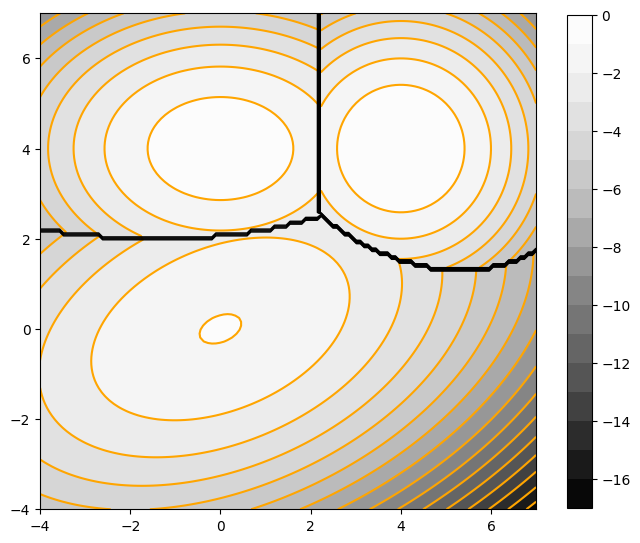

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.set(aspect='equal')
ax.contour(x1, x2, maxpx.reshape(x1.shape), 16, colors='orange', linestyles='solid')
cp = ax.contourf(x1, x2, maxpx.reshape(x1.shape), 16, cmap='Greys_r')
ax.contour(x1, x2, amaxpx.reshape(x1.shape), colors='black', linestyles='solid', linewidths=1)
plt.colorbar(cp, ax=ax, shrink=0.8);

<p style="page-break-after:always;"></p>

## 2.3 Análisis discriminante lineal (LDA)

**Análisis discriminante lineal (LDA):** $\;$ GDA con Gaussianas de **matriz de covarianza común,** $\;\mathbf{\Sigma}_c=\mathbf{\Sigma}$
$$\log p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})%
\propto\log\pi_c+\log\mathcal{N}_D(\boldsymbol{\mu}_c,\mathbf{\Sigma})$$

**Discriminantes lineales con $\boldsymbol{x}$:** $\;$ al igual que $\kappa$, el término cuadrático puede ignorarse porque no depende de $c$
$$\begin{align*}
\log p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})%
&\propto\log\pi_c-\frac{D}{2}\log(2\pi)-\frac{1}{2}\log\vert\mathbf{\Sigma}\vert
-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu}_c)^t\mathbf{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu}_c)\\%
&=\boldsymbol{x}^t\mathbf{A}\boldsymbol{x}+\boldsymbol{\beta}_c^t\boldsymbol{x}+\gamma_c+\kappa\\%
\mathbf{A}&=-\frac{1}{2}\mathbf{\Sigma}^{-1}\\%
\boldsymbol{\beta}_c&=\mathbf{\Sigma}^{-1}\boldsymbol{\mu}_c\\%
\gamma_c&=\log\pi_c-\frac{1}{2}\boldsymbol{\mu}_c^t\mathbf{\Sigma}^{-1}\boldsymbol{\mu}_c\\%
\kappa&=-\frac{D}{2}\log(2\pi)-\frac{1}{2}\log\vert\mathbf{\Sigma}\vert%
\end{align*}$$

<p style="page-break-after:always;"></p>

**Ejemplo:** $\;C=3$, $\;D=2$, $\;\pi_1=\pi_2=\pi_3=1/3$ (podemos ignorar $\log \pi_c$ en $\gamma_c$)
$$\begin{align*}
\boldsymbol{\mu}_1&=(0, 0)^t & \boldsymbol{\mu}_2&=(0, 4)^t & \boldsymbol{\mu}_3&=(4, 4)^t\\%
\mathbf{\Sigma}&=\begin{pmatrix}1&0\\0&1\end{pmatrix}&%
\mathbf{\Sigma}^{-1}&=\begin{pmatrix}1&0\\0&1\end{pmatrix}&&\\%
\boldsymbol{\beta}_1&=(0, 0)^t & \boldsymbol{\beta}_2&=(0,4)^t & \boldsymbol{\beta}_3&=(4,4)^t\\%
\gamma_1&=0 & \gamma_2&=-8 & \gamma_3&= -16%
\end{align*}$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
b1, c1 = np.array([0, 0]), 0
b2, c2 = np.array([0, 4]), -8
b3, c3 = np.array([4, 4]), -16
x1, x2 = np.meshgrid(np.linspace(-4, 7, num=128), np.linspace(-4, 7, num=128))
x = np.c_[np.ravel(x1), np.ravel(x2)]
p1 =  lambda x: b1 @ x + c1
p2 =  lambda x: b2 @ x + c2
p3 =  lambda x: b3 @ x + c3
maxp = lambda x: max(p1(x), p2(x), p3(x))
maxpx = np.apply_along_axis(maxp, 1, x)
amaxp = lambda x: np.argmax([p1(x), p2(x), p3(x)])
amaxpx = np.apply_along_axis(amaxp, 1, x)


<p style="page-break-after:always;"></p>


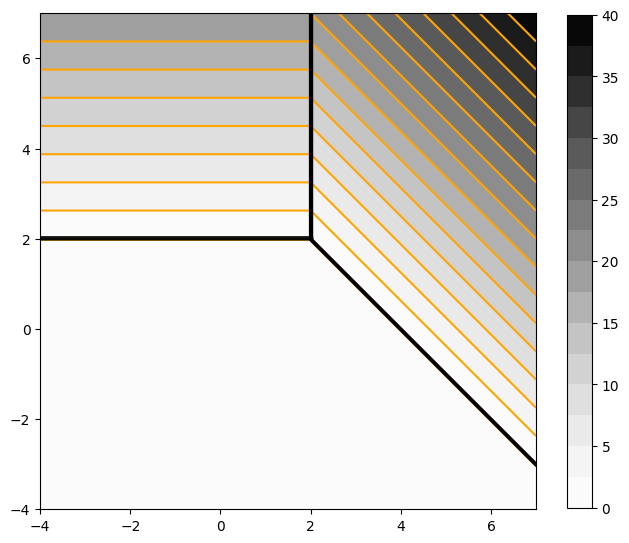

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set(aspect='equal')
ax.contour(x1, x2, maxpx.reshape(x1.shape), 16, colors='orange', linestyles='solid')
cp = ax.contourf(x1, x2, maxpx.reshape(x1.shape), 16, cmap='Greys')
ax.contour(x1, x2, amaxpx.reshape(x1.shape), colors='black', linestyles='solid', linewidths=1)
plt.colorbar(cp, ax=ax, shrink=0.8);

<p style="page-break-after:always;"></p>

Los conjuntos de nivel típicos de las Gaussianas pueden obtenerse añadiendo el término cuadrático común a las discriminantes, si bien el mismo es irrelevante a efectos de regiones y fronteras de decisión:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
A1, b1, c1 = np.array([ [-1/2,    0], [   0,  -1/2] ]), np.array([0, 0]), -0.973
A2, b2, c2 = np.array([ [-1/2,    0], [   0,  -1/2] ]), np.array([0, 4]), -8.3466
A3, b3, c3 = np.array([ [-1/2,    0], [   0,  -1/2] ]), np.array([4, 4]), -16
x1, x2 = np.meshgrid(np.linspace(-4, 7, num=128), np.linspace(-4, 7, num=128))
x = np.c_[np.ravel(x1), np.ravel(x2)]
p1 =  lambda x: x.T @ A1 @ x + b1 @ x + c1
p2 =  lambda x: x.T @ A2 @ x + b2 @ x + c2
p3 =  lambda x: x.T @ A3 @ x + b3 @ x + c3
maxp = lambda x: max(p1(x), p2(x), p3(x))
maxpx = np.apply_along_axis(maxp, 1, x)
amaxp = lambda x: np.argmax([p1(x), p2(x), p3(x)])
amaxpx = np.apply_along_axis(amaxp, 1, x)


<p style="page-break-after:always;"></p>


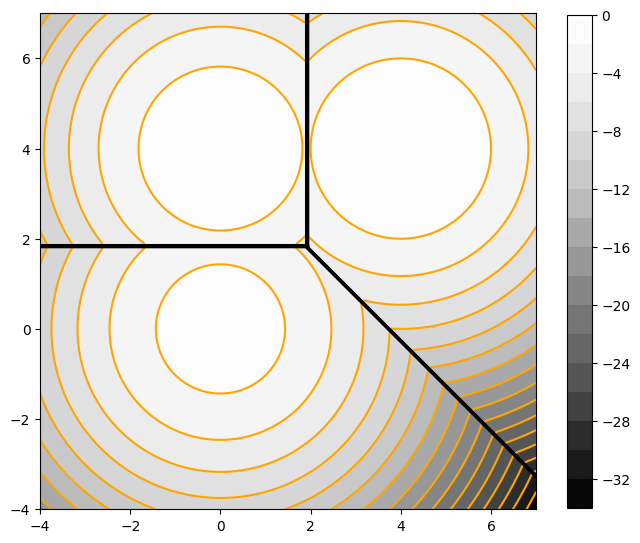

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set(aspect='equal')
ax.contour(x1, x2, maxpx.reshape(x1.shape), 16, colors='orange', linestyles='solid')
cp = ax.contourf(x1, x2, maxpx.reshape(x1.shape), 16, cmap='Greys_r')
ax.contour(x1, x2, amaxpx.reshape(x1.shape), colors='black', linestyles='solid', linewidths=1)
plt.colorbar(cp, ax=ax, shrink=0.8);

<p style="page-break-after:always;"></p>

## 2.4 Ajuste del modelo

### 2.4.1 Ajuste de modelos generativos con la conjunta

**Parámetros:** $\;\boldsymbol{\theta}=(\boldsymbol{\pi}, \boldsymbol{\theta}'),\,$ donde $\boldsymbol{\pi}$ son las priors de las clases y $\boldsymbol{\theta}'$ los parámetros que gobiernan las condicionales de las clases

**Función de probabilidad a priori de las etiquetas de clase:** $\;$ categórica gobernada por $\boldsymbol{\pi}$
$$p(y\mid\boldsymbol{\pi})=\operatorname{Cat}(y\mid\boldsymbol{\pi})=\prod_c \pi_c^{\mathbb{I}(y=c)}$$

**Función de verosimilitud conjunta:** $\;$ de $\,\boldsymbol{\theta}\,$ respecto a $N$ datos, $\,\mathcal{D}=\{(\boldsymbol{x}_n,y_n)\}$
$$\begin{align*}
p(\mathcal{D}\mid\boldsymbol{\theta})%
&=\prod_n p(\boldsymbol{x}_n,y_n\mid\boldsymbol{\theta})&&\text{(muestras i.i.d.)}\\%
&=\prod_n p(y_n\mid\boldsymbol{\pi})\,p(\boldsymbol{x}_n\mid y_n, \boldsymbol{\theta}')&&\text{(regla producto)}\\%
&=\prod_n \prod_c (p(y_n=c\mid\boldsymbol{\pi})\,p(\boldsymbol{x}_n\mid y_n=c, \boldsymbol{\theta}'))^{\mathbb{I}(y_n=c)}%
&&\text{(explicitando $c$)}\\%
&=\prod_c \prod_n \pi_c^{\mathbb{I}(y_n=c)}\prod_c \prod_n p(\boldsymbol{x}_n\mid y_n=c, \boldsymbol{\theta}')^{\mathbb{I}(y_n=c)}%
&&\text{(reodenando factores)}
\end{align*}$$

**Función de log-verosimilitud conjunta:** $\;$ sea $\;N_c=\sum_n\mathbb{I}(y_n=c)$
$$\begin{align*}
\log p(\mathcal{D}\mid\boldsymbol{\theta})%
&=\left[\sum_c\sum_n\mathbb{I}(y_n=c)\log\pi_c\right] +
\left[\sum_c\sum_n\mathbb{I}(y_n=c)\log p(\boldsymbol{x}_n\mid y_n=c, \boldsymbol{\theta}')\right]\\%
&=\sum_c N_c\log\pi_c + \sum_c\sum_{n:y_n=c}\log p(\boldsymbol{x}_n\mid y_n=c, \boldsymbol{\theta}')%
\end{align*}$$

<p style="page-break-after:always;"></p>

**Maximización:** $\;$ el MLE de la conjunta, $\hat{\boldsymbol{\theta}}=(\hat{\boldsymbol{\pi}}, \hat{\boldsymbol{\theta}}')$, puede hallarse mediante maximización separada en $\boldsymbol{\pi}$ y $\boldsymbol{\theta}'$ (con restricciones)
$$\hat{\boldsymbol{\theta}}=\operatorname*{argmax}_{\boldsymbol{\theta}}\;\log p(\mathcal{D}\mid\boldsymbol{\theta})%
\quad\Leftrightarrow\quad%
\hat{\boldsymbol{\pi}}=\operatorname*{argmax}_{\boldsymbol{\pi}\in\mathcal{C}_{\boldsymbol{\pi}}}\sum_c N_c\log\pi_c%
\quad\text{y}\quad%
\hat{\boldsymbol{\theta}}'=\operatorname*{argmax}_{\boldsymbol{\theta}'\in\mathcal{C}_{\boldsymbol{\theta}'}}\sum_c\sum_{n:y_n=c}\log p(\boldsymbol{x}_n\mid y_n=c, \boldsymbol{\theta}')$$

**Maximización en $\boldsymbol{\pi}$:** $\;$ sujeta a las restricciones de probabilidad; introducimos un multiplicador de Lagrange para la de igualdad (suma $1$)
$$\hat{\boldsymbol{\pi}}=\operatorname*{argmax}_{\boldsymbol{\pi}}\;\max_{\lambda}\;%
\sum_c N_c\log\pi_c+\lambda\left(\left(\sum_c\pi_c\right)-1\right)\quad\Rightarrow\quad\hat{\pi}_c=\frac{N_c}{N}$$

<p style="page-break-after:always;"></p>

### 2.4.2 Análisis discriminante cuadrático (QDA)

**Log-verosimilitud conjunta:** $\;\boldsymbol{\theta}'=\{\boldsymbol{\theta}_c\},\,$ $\boldsymbol{\theta}_c=(\boldsymbol{\mu}_c^t, \operatorname{vec}(\mathbf{\Sigma}_c))^t$
$$\begin{align*}
\log p(\mathcal{D}\mid\boldsymbol{\theta})%
&=\sum_c N_c\log\pi_c + \sum_c\sum_{n:y_n=c}\log \mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma}_c)\\%
\end{align*}$$

**Maximización en $\boldsymbol{\theta}'$:** $\;\hat{\boldsymbol{\theta}}'\,$ puede hallarse mediante maximización separada en
cada $\boldsymbol{\theta}_c$ (con restricciones)
$$\hat{\boldsymbol{\theta}}'=\operatorname*{argmax}_{\boldsymbol{\theta}'\in\mathcal{C}_{\boldsymbol{\theta}'}}\sum_c\sum_{n:y_n=c}\log \mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma}_c)%
\quad\Leftrightarrow\quad%
\hat{\boldsymbol{\theta}}_c=\operatorname*{argmax}_{\boldsymbol{\theta}_c\in\mathcal{C}_{\boldsymbol{\theta}_c}}\sum_{n:y_n=c}\log \mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma}_c)\quad\text{para todo $c$}$$

**Maximización en $\boldsymbol{\theta}_c'$:** $\;$ $\hat{\boldsymbol{\mu}}_c$ y $\hat{\mathbf{\Sigma}}_c$ se hallan a partir de los datos de la clase $c$ como si se tratara del MLE de una única Gaussiana
$$\begin{align*}
\hat{\boldsymbol{\mu}}_c&=\frac{1}{N_c}\sum_{n:y_n=c}\boldsymbol{x}_n\\%
\hat{\mathbf{\Sigma}}_c&=\frac{1}{N_c}\sum_{n:y_n=c}(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)^t%
\end{align*}$$

<p style="page-break-after:always;"></p>

**Ejemplo:** $\;C=3$, $\;D=2$, $\;\pi_1=\pi_2=\pi_3=1/3$
$$\begin{align*}
\boldsymbol{\mu}_1&=(0, 0)^t & \boldsymbol{\mu}_2&=(0, 4)^t & \boldsymbol{\mu}_3&=(4, 4)^t\\%
\mathbf{\Sigma}_1&=\begin{pmatrix}4&1\\1&2\end{pmatrix}%
&\mathbf{\Sigma}_2&=\begin{pmatrix}2&0\\0&1\end{pmatrix}%
&\mathbf{\Sigma}_3&=\begin{pmatrix}1&0\\0&1\end{pmatrix}%
\end{align*}$$

In [7]:
import numpy as np; import matplotlib.pyplot as plt; from scipy.stats import multinomial, multivariate_normal
N = 50 # >=3 para tener al menos un dato por clase; >>3 para evitar matrices singulares
pi1 = pi2 = pi3 = 1/3
yy = multinomial(1, [pi1, pi2, pi3]).rvs(N - 3)
N1 = yy[yy[:, 0] == 1].shape[0] + 1
N2 = yy[yy[:, 1] == 1].shape[0] + 1
N3 = N - N1 - N2
hpi1 = N1/N; hpi2 = N2/N; hpi3 = N3/N
xxy1 = multivariate_normal([0, 0], [[4, 1], [1, 2]]).rvs(N1)
m1 = xxy1.mean(axis=0); S1 = np.cov(xxy1, rowvar=False, bias=True); iS1 = np.linalg.inv(S1)
xxy2 = multivariate_normal([0, 4], [[2, 0], [0, 1]]).rvs(N2)
m2 = xxy2.mean(axis=0); S2 = np.cov(xxy2, rowvar=False, bias=True); iS2 = np.linalg.inv(S2)
xxy3 = multivariate_normal([4, 4], np.eye(2)).rvs(N3)
m3 = xxy3.mean(axis=0); S3 = np.cov(xxy3, rowvar=False, bias=True); iS3 = np.linalg.inv(S3)
print("Medias: ", m1, m2, m3, "\nSigmas:\n", S1, "\n", S2, "\n", S3)

Medias:  [ 0.02615284 -0.10613114] [0.0141229  3.67640528] [3.86130147 4.39863792] 
Sigmas:
 [[3.26723187 0.01448241]
 [0.01448241 1.37209543]] 
 [[3.01639217 0.35899633]
 [0.35899633 0.82111174]] 
 [[ 1.80168196 -0.29109154]
 [-0.29109154  0.99467958]]



<p style="page-break-after:always;"></p>


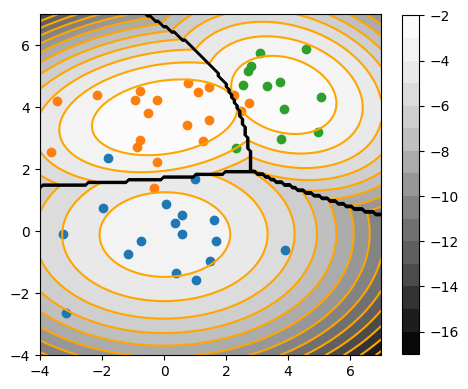

In [8]:
A1, b1, c1 = -0.5 * iS1, iS1 @ m1, np.log(hpi1) - 0.5 * np.linalg.det(S1) - 0.5 * m1.T @ iS1 @ m1
A2, b2, c2 = -0.5 * iS2, iS2 @ m2, np.log(hpi2) - 0.5 * np.linalg.det(S2) - 0.5 * m2.T @ iS2 @ m2
A3, b3, c3 = -0.5 * iS3, iS3 @ m3, np.log(hpi3) - 0.5 * np.linalg.det(S3) - 0.5 * m3.T @ iS3 @ m3
x1, x2 = np.meshgrid(np.linspace(-4, 7, num=128), np.linspace(-4, 7, num=128))
x = np.c_[np.ravel(x1), np.ravel(x2)]; p1 =  lambda x: x.T @ A1 @ x + b1 @ x + c1
p2 =  lambda x: x.T @ A2 @ x + b2 @ x + c2; p3 =  lambda x: x.T @ A3 @ x + b3 @ x + c3
maxp = lambda x: max(p1(x), p2(x), p3(x)); maxpx = np.apply_along_axis(maxp, 1, x)
amaxp = lambda x: np.argmax([p1(x), p2(x), p3(x)]); amaxpx = np.apply_along_axis(amaxp, 1, x)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5)); ax.set(aspect='equal')
ax.contour(x1, x2, maxpx.reshape(x1.shape), 16, colors='orange', linestyles='solid')
cp = ax.contourf(x1, x2, maxpx.reshape(x1.shape), 16, cmap='Greys_r')
ax.contour(x1, x2, amaxpx.reshape(x1.shape), colors='black', linestyles='solid', linewidths=1)
plt.colorbar(cp, ax=ax, shrink=0.8); ax.set_xlim(-4, 7); ax.set_ylim(-4, 7)
plt.scatter(xxy1[:, 0], xxy1[:, 1]); plt.scatter(xxy2[:, 0], xxy2[:, 1])
plt.scatter(xxy3[:, 0], xxy3[:, 1]);

<p style="page-break-after:always;"></p>

### 2.4.3 Análisis discriminante lineal (LDA)

**Log-verosimilitud conjunta:** $\;\boldsymbol{\theta}'=(\boldsymbol{\mu}_1^t,\dotsc,\boldsymbol{\mu}_C^t,\operatorname{vec}(\mathbf{\Sigma}))^t$
$$\begin{align*}
\log p(\mathcal{D}\mid\boldsymbol{\theta})%
&=\sum_c N_c\log\pi_c + \sum_c\sum_{n:y_n=c}\log \mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma})\\%
\end{align*}$$

**Maximización en $\boldsymbol{\theta}'$:** $\;$ no puede hacerse clase a clase, separadamente, porque las condicionales comparten una misma $\mathbf{\Sigma}$
$$\hat{\boldsymbol{\theta}}'=\operatorname*{argmax}_{\boldsymbol{\theta}'\in\mathcal{C}_{\boldsymbol{\theta}'}}\sum_c\sum_{n:y_n=c}\log \mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma})$$
No obstante, la única diferencia respecto a QDA es que $\hat{\mathbf{\Sigma}}$ se obtiene con todos los datos:
$$\begin{align*}
\hat{\boldsymbol{\mu}}_c&=\frac{1}{N_c}\sum_{n:y_n=c}\boldsymbol{x}_n\\%
\hat{\mathbf{\Sigma}}&=\frac{1}{N}\sum_c\sum_{n:y_n=c}(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)^t%
\end{align*}$$

<p style="page-break-after:always;"></p>

**Ejemplo:** $\;C=3$, $\;D=2$, $\;\pi_1=\pi_2=\pi_3=1/3$
$$\begin{align*}
\boldsymbol{\mu}_1&=(0, 0)^t & \boldsymbol{\mu}_2&=(0, 4)^t & \boldsymbol{\mu}_3&=(4, 4)^t\\%
\mathbf{\Sigma}&=\begin{pmatrix}1&0\\0&1\end{pmatrix}&%
\mathbf{\Sigma}^{-1}&=\begin{pmatrix}1&0\\0&1\end{pmatrix}&&%
\end{align*}$$

In [9]:
import numpy as np; import matplotlib.pyplot as plt; from scipy.stats import multinomial, multivariate_normal
N = 50 # >=3 para tener al menos un dato por clase; >>3 para evitar matrices singulares
pi1 = pi2 = pi3 = 1/3
yy = multinomial(1, [pi1, pi2, pi3]).rvs(N - 3)
N1 = yy[yy[:, 0] == 1].shape[0] + 1
N2 = yy[yy[:, 1] == 1].shape[0] + 1
N3 = N - N1 - N2
hpi1 = N1/N; hpi2 = N2/N; hpi3 = N3/N
xxy1 = multivariate_normal([0, 0], np.eye(2)).rvs(N1)
m1 = xxy1.mean(axis=0); S1 = np.cov(xxy1, rowvar=False, bias=True)
xxy2 = multivariate_normal([0, 4], np.eye(2)).rvs(N2)
m2 = xxy2.mean(axis=0); S2 = np.cov(xxy2, rowvar=False, bias=True)
xxy3 = multivariate_normal([4, 4], np.eye(2)).rvs(N3)
m3 = xxy3.mean(axis=0); S3 = np.cov(xxy3, rowvar=False, bias=True)
S = hpi1 * S1 + hpi2 * S2 + hpi3 * S3; iS = np.linalg.inv(S)
print("Medias: ", m1, m2, m3, "\nSigma:\n", S)

Medias:  [0.16135894 0.20061893] [0.21307716 3.53490208] [4.21657565 4.08759674] 
Sigma:
 [[ 0.72951846 -0.11534718]
 [-0.11534718  0.67319603]]



<p style="page-break-after:always;"></p>


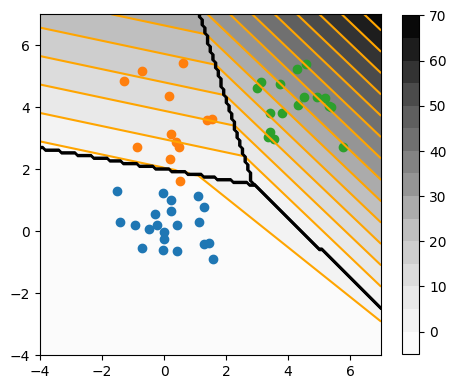

In [10]:
b1, c1 = iS @ m1, np.log(hpi1) - 0.5 * m1.T @ iS @ m1
b2, c2 = iS @ m2, np.log(hpi2) - 0.5 * m2.T @ iS @ m2
b3, c3 = iS @ m3, np.log(hpi3) - 0.5 * m3.T @ iS @ m3
x1, x2 = np.meshgrid(np.linspace(-4, 7, num=128), np.linspace(-4, 7, num=128))
x = np.c_[np.ravel(x1), np.ravel(x2)]
p1 =  lambda x: b1 @ x + c1; p2 =  lambda x: b2 @ x + c2; p3 =  lambda x: b3 @ x + c3
maxp = lambda x: max(p1(x), p2(x), p3(x)); maxpx = np.apply_along_axis(maxp, 1, x)
amaxp = lambda x: np.argmax([p1(x), p2(x), p3(x)]); amaxpx = np.apply_along_axis(amaxp, 1, x)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5)); ax.set(aspect='equal')
ax.contour(x1, x2, maxpx.reshape(x1.shape), 16, colors='orange', linestyles='solid')
cp = ax.contourf(x1, x2, maxpx.reshape(x1.shape), 16, cmap='Greys')
ax.contour(x1, x2, amaxpx.reshape(x1.shape), colors='black', linestyles='solid', linewidths=1)
plt.colorbar(cp, ax=ax, shrink=0.8); ax.set_xlim(-4, 7); ax.set_ylim(-4, 7)
plt.scatter(xxy1[:, 0], xxy1[:, 1]); plt.scatter(xxy2[:, 0], xxy2[:, 1])
plt.scatter(xxy3[:, 0], xxy3[:, 1]);

<p style="page-break-after:always;"></p>

### 2.4.4 Matrices de covarianzas diagonales

**Motivación:** $\;$ aunque perdemos capacidad para capturar correlaciones entre variables, el número de parámetros pasa de cuadrático a lineal con $D$, cosa muy conveniente en la práctica cuando $D$ es grande

**QDA diagonal:** $\;$ reduce el número de parámetros de $\,O(CD^2)\,$ a $\,O(CD)$

**LDA diagonal:** $\;$ reduce el número de parámetros de $\,O(CD+D^2)\,$ a $\,O(CD)$

### 2.4.5 Análisis discriminante regularizado

**Análisis discriminante regularizado (RDA):** $\;$ introduce un hiperparámetro de regularización $\lambda\in[0,1]$ con el fin de hallar un compromiso (no necesariamente extremo) entre una matriz de covarianzas completa y su diagonal,
$$\hat{\mathbf{\Sigma}}_{\text{rda}}=\lambda\operatorname{diag}(\hat{\mathbf{\Sigma}}_{\text{mle}})+(1-\lambda)\hat{\mathbf{\Sigma}}_{\text{mle}}$$



<p style="page-break-after:always;"></p>

## 2.5 Clasificador por el centroide más próximo


**Clasificador por el centroide más próximo (NCM):** $\;$ regla de decisión MAP para LDA con priors idénticos,
$$\begin{align*}
\hat{y}(\boldsymbol{x})%
&=\operatorname*{argmax}_c\;\log p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})\\%
&=\operatorname*{argmax}_c\;\log p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta})%
&&\text{(asumiendo priors idénticos)}\\%
&=\operatorname*{argmax}_c\;-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu}_c)^t\mathbf{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu}_c)\\%
&=\operatorname*{argmin}_c\;(\boldsymbol{x}-\boldsymbol{\mu}_c)^t\mathbf{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu}_c)\\%
&=\operatorname*{argmin}_c\;\Vert\boldsymbol{x}-\boldsymbol{\mu}_c\Vert_{\mathbf{W}}^2%
&&\text{(con $\mathbf{\Sigma}^{-1}=\mathbf{W}^t\mathbf{W}$, $\;\Vert\boldsymbol{z}\Vert_{\mathbf{W}}^2=\boldsymbol{z}^t\mathbf{W}^t\mathbf{W}\boldsymbol{z}$)}%
\end{align*}$$

**Motivación:** $\;$ aparte de su sencillez y reducido coste computacional, puede usarse en **one-shot learning** de nuevas clases ya que basta añadir un prototipo etiquetado $\boldsymbol{\mu}_c$ por cada clase $c$ nueva que se quiera incluir

**Aprendizaje de la métrica:** $\;$ $\mathbf{W}$ puede ser una raíz de $\mathbf{\Sigma}^{-1}$ o aprenderse con algún criterio discriminativo

<p style="page-break-after:always;"></p>

# 3 Clasificadores naive Bayes

## 3.1 Asunción y clasificador naive Bayes

**Asunción naive Bayes:** $\;$ $\boldsymbol{\theta}_c=(\boldsymbol{\theta}_{c1},\dotsc,\boldsymbol{\theta}_{cD}),\,$ $\boldsymbol{\theta}_{cd}\,$ gobierna la distribución de la característica **independiente** $d$ en la clase $c$

$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\prod_{d=1}^D p(x_d\mid y=c,\boldsymbol{\theta}_{cd})$$

**Clasificador naive Bayes (NBC):** $\;$ modelo generativo basado en la asunción naive Bayes
$$p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})=\frac{\pi_c\,p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)}{\sum_{c'}\pi_{c'}\,p(\boldsymbol{x}\mid y=c',\boldsymbol{\theta}_{c'})}\propto \pi_c\,p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)$$

**Motivación:** $\;$ aunque se llama "naive" porque es de ingenuos creer que esta asunción se cumple en la práctica, facilita el desarrollo de modelos sencillos, fáciles de entrenar y sorprendentemente precisos (en algunas tareas)

<p style="page-break-after:always;"></p>

## 3.2 Modelos ejemplo

### 3.2.1 Naive Bayes Bernoulli

Para características binarias, $x_d\in\{0,1\}$; $\;\boldsymbol{\theta}_c=(\theta_{c1},\dotsc,\theta_{cD})^t$ y $\theta_{cd}$ es la probabilidad de que $x_d=1$ en la clase $c$
$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\prod_{d=1}^D \operatorname{Ber}(x_d\mid\theta_{cd})$$

**Ejemplo:** $\;C=2$, $\;\pi_1=\pi_2=0.5,\,$ $D=2,\,$ $\boldsymbol{\theta}_1=(0.7, 0.3)^t,\,$ $\boldsymbol{\theta}_2=(0.2, 0.8)^t,\,$ $\boldsymbol{x}=(1,0)^t$
$$\begin{align*}
p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)%
&=\operatorname{Ber}(x_1\mid 0.7)\,\operatorname{Ber}(x_2\mid 0.3)=0.7\cdot 0.7=0.49\\%
p(\boldsymbol{x}\mid y=2,\boldsymbol{\theta}_2)%
&=\operatorname{Ber}(x_1\mid 0.2)\,\operatorname{Ber}(x_2\mid 0.8)=0.2\cdot 0.2=0.04\\%
p(y=1\mid\boldsymbol{x},\boldsymbol{\theta})%
&=\frac{p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)}
{p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)+p(\boldsymbol{x}\mid y=2,\boldsymbol{\theta}_2)}%
&&(\text{priors equiprobables})\\%
&=\frac{0.49}{0.49+0.04}=0.92%
\end{align*}$$

<p style="page-break-after:always;"></p>

### 3.2.2 Naive Bayes categórico

Para características categóricas, $x_d\in\{1,\dotsc,K_d\};\;$ $\boldsymbol{\theta}_c=(\boldsymbol{\theta}_{c1},\dotsc,\boldsymbol{\theta}_{cD}),\,$ $\boldsymbol{\theta}_{cd}\in[0,1]^{K_d}\,$ y $\,\theta_{cdk}\,$ es la probabilidad de que $x_d=k$ en la clase $c$
$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\prod_{d=1}^D \operatorname{Cat}(x_d\mid\boldsymbol{\theta}_{cd})$$

**Ejemplo:** $\;C=2$, $\;\pi_1=\pi_2=0.5$, $\;D=2$, $\;K_1=K_2=3$, $\;\boldsymbol{x}=(1,2)^t$
$$\begin{align*}
\boldsymbol{\theta}_{11}&=(0.6, 0.2, 0.2)^t & \boldsymbol{\theta}_{12}&=(0.1, 0.3, 0.6)^t\\
\boldsymbol{\theta}_{21}&=(0.3, 0.4, 0.3)^t & \boldsymbol{\theta}_{22}&=(0.3, 0.2, 0.5)^t%
\end{align*}$$
$$\begin{align*}
p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)%
&=\operatorname{Cat}(x_1\mid\boldsymbol{\theta}_{11})\,\operatorname{Cat}(x_2\mid\boldsymbol{\theta}_{12})=0.6\cdot 0.3=0.18\\%
p(\boldsymbol{x}\mid y=2,\boldsymbol{\theta}_2)%
&=\operatorname{Cat}(x_1\mid\boldsymbol{\theta}_{21})\,\operatorname{Cat}(x_2\mid\boldsymbol{\theta}_{22})=0.3\cdot 0.2=0.06\\%
p(y=1\mid\boldsymbol{x},\boldsymbol{\theta})%
&=\frac{0.18}{0.18+0.06}=0.75&&(\text{priors equiprobables})%
\end{align*}$$

<p style="page-break-after:always;"></p>

### 3.2.3 Naive Bayes Gaussiano

Para características reales, $x_d\in\mathbb{R};\;$ $\boldsymbol{\theta}_c=(\boldsymbol{\theta}_{c1},\dotsc,\boldsymbol{\theta}_{cD})^t$, $\boldsymbol{\theta}_{cd}=(\mu_{cd},\sigma_{cd}^2)$, media y varianza de la característica $d$ en $c$
$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\prod_{d=1}^D \mathcal{N}(x_d\mid\mu_{cd},\sigma_{cd}^2)$$

**Ejemplo:** $\;C=2,\,$ $\pi_1=\pi_2=0.5,\,$ $D=2,\,$ $\boldsymbol{x}=(0, 1)^t$
$$\begin{align*}
\boldsymbol{\theta}_1&=(\boldsymbol{\mu}_1,\boldsymbol{\sigma}_1^2)^t%
&\boldsymbol{\mu}_1&=(\mu_{11},\mu_{12})^t=(-2,0)^t%
&\boldsymbol{\sigma}_1^2&=(\sigma_{11}^2, \sigma_{12}^2)^t=\boldsymbol{1}\\%
\boldsymbol{\theta}_2&=(\boldsymbol{\mu}_2,\boldsymbol{\sigma}_2^2)^t%
&\boldsymbol{\mu}_2&=(\mu_{21},\mu_{22})^t=(2,0)^t%
&\boldsymbol{\sigma}_2^2&=(\sigma_{21}^2, \sigma_{22}^2)^t=\boldsymbol{1}%
\end{align*}$$
$$\begin{align*}
p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)%
&=\mathcal{N}(x_1\mid\mu_{11},\sigma_{11}^2)\,\mathcal{N}(x_2\mid\mu_{12},\sigma_{12}^2)%
=\mathcal{N}(\boldsymbol{x}\mid\boldsymbol{\mu}_1,\mathbf{\Sigma}_1),\;%
\mathbf{\Sigma}_1=\operatorname{diag}(\boldsymbol{\sigma}_1^2)\\%
p(\boldsymbol{x}\mid y=2,\boldsymbol{\theta}_2)%
&=\mathcal{N}(x_1\mid\mu_{21},\sigma_{21}^2)\,\mathcal{N}(x_2\mid\mu_{22},\sigma_{22}^2)%
=\mathcal{N}(\boldsymbol{x}\mid\boldsymbol{\mu}_2,\mathbf{\Sigma}_2),\;%
\mathbf{\Sigma}_2=\operatorname{diag}(\boldsymbol{\sigma}_2^2)\\%
p(y=1\mid\boldsymbol{x},\boldsymbol{\theta})%
&=\frac{p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)}
{p(\boldsymbol{x}\mid y=1,\boldsymbol{\theta}_1)+p(\boldsymbol{x}\mid y=2,\boldsymbol{\theta}_2)}%
&&(\text{priors equiprobables})
\end{align*}$$

In [1]:
import numpy as np; from scipy.stats import multivariate_normal
mu1 = np.array([-2, 0]); mu2 = np.array([2, 0]);  Sigma1 = Sigma2 = np.eye(2); x = np.array([0, 1])
pxy1 = multivariate_normal.pdf(x, mu1, Sigma1); pxy2 = multivariate_normal.pdf(x, mu2, Sigma2)
py1x = pxy1 / (pxy1 + pxy2); print(py1x)

0.5
